# Import Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data from local drive
from google.colab import files
uploaded = files.upload()

# Data structure read
df_data = pd.read_csv('ionosphere_modified.csv')
df_data.head()

Saving ionosphere_modified.csv to ionosphere_modified (1).csv


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Label
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


# Visualization

Label Distribution:
g    225
b    126
Name: Label, dtype: int64


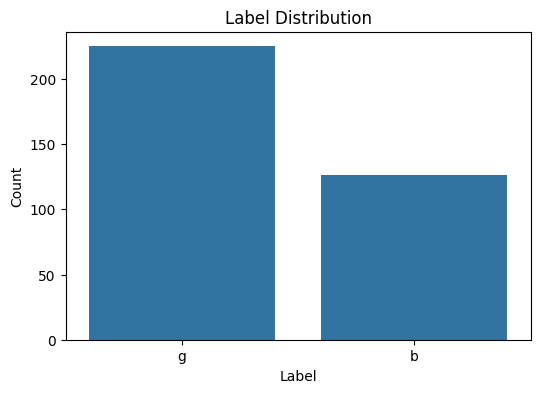

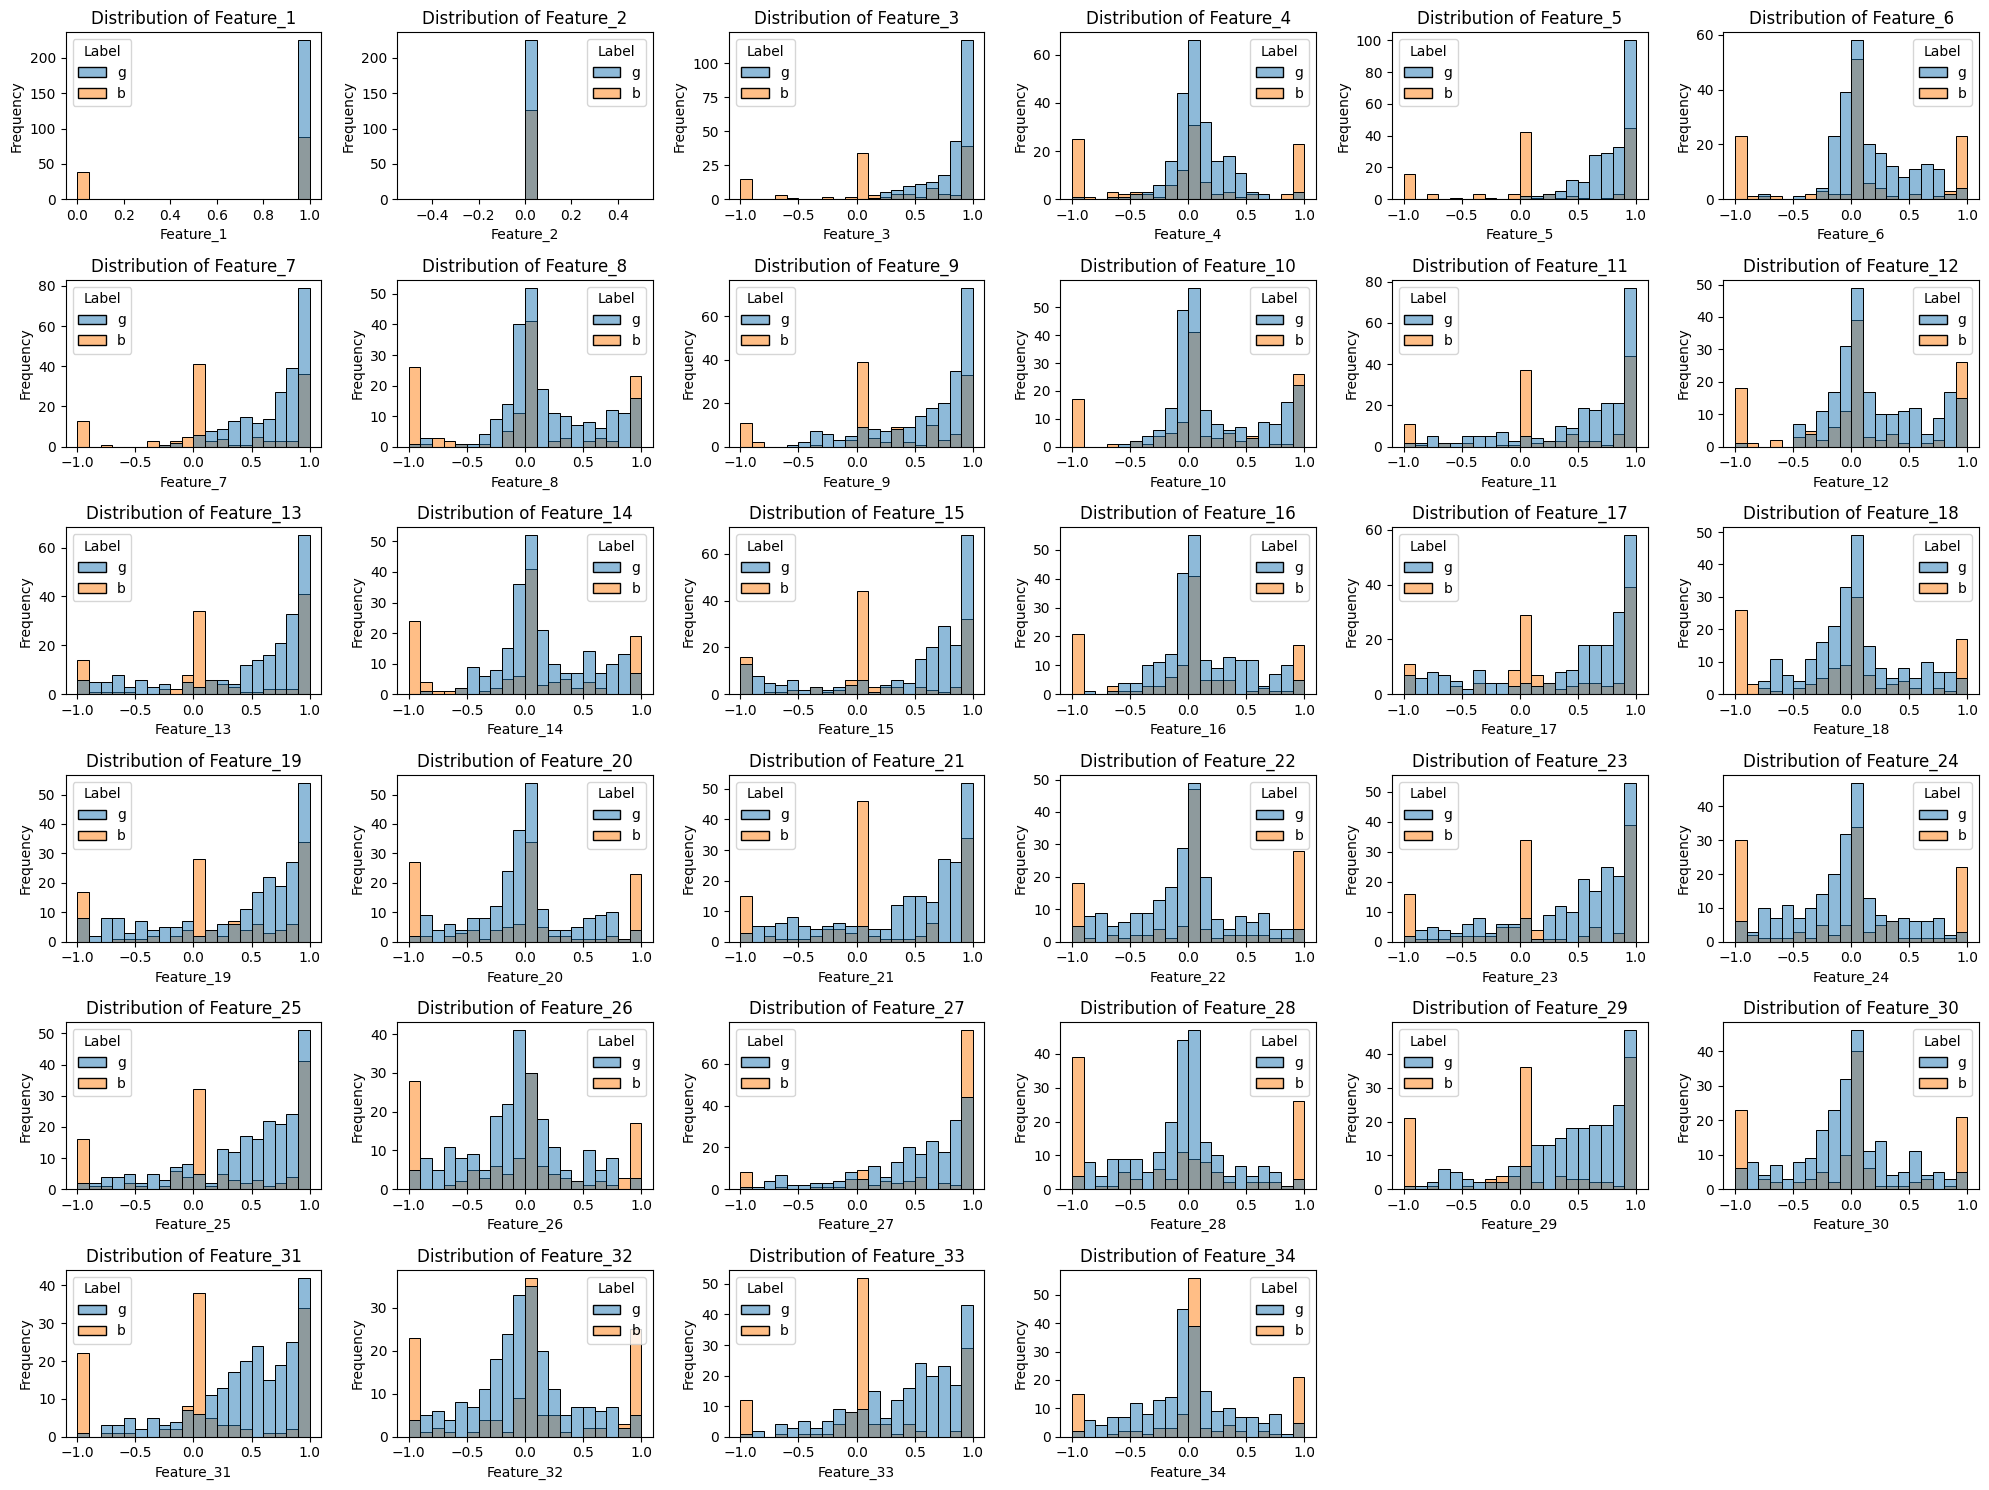

<ipython-input-2-fa693b791db3>:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_data.corr()


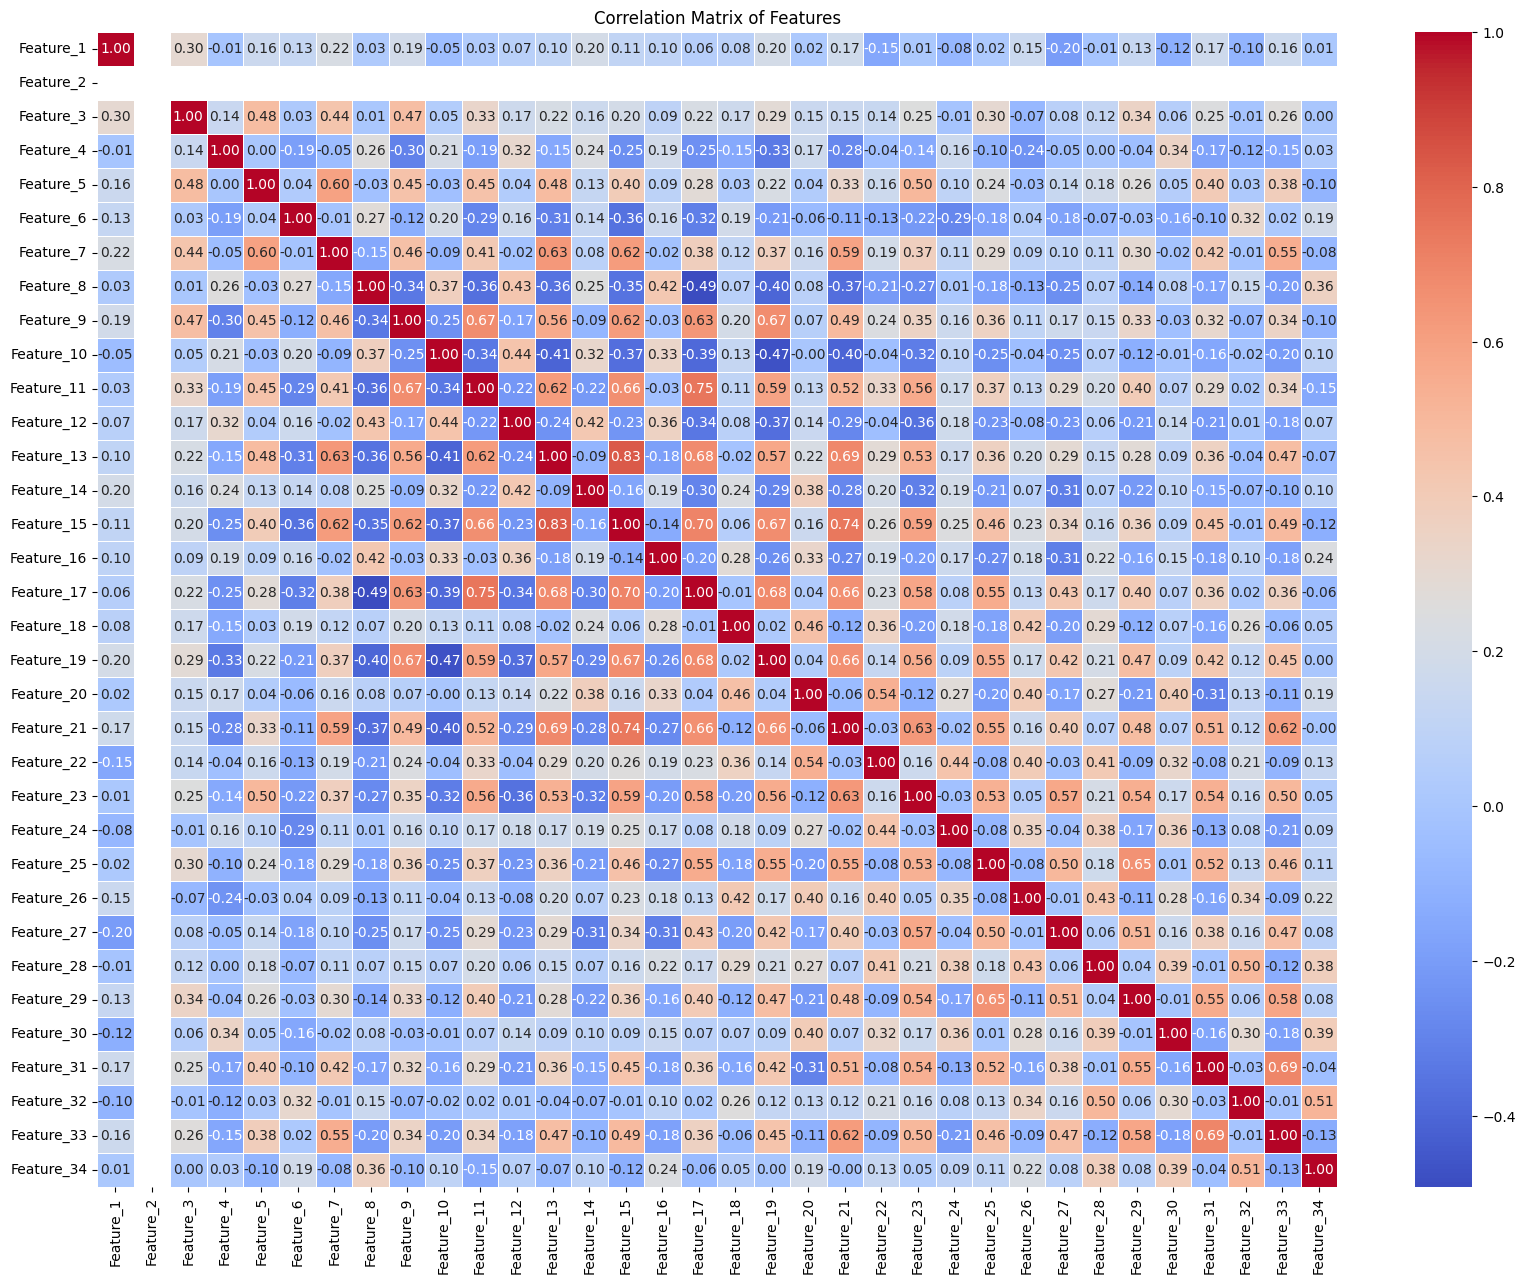

In [ ]:
# Analyze class distribution
import seaborn as sns

Label_distribution = df_data['Label'].value_counts()
print("Label Distribution:")
print(Label_distribution)

# Visualize Label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df_data)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig("Class dist - 2.png")
plt.show()

# Visualize distributions of all features with respect to Label
plt.figure(figsize=(20, 15))
for i in range(1, 35):
    feature_name = f'Feature_{i}'
    plt.subplot(6, 6, i)
    sns.histplot(data=df_data, x=feature_name, hue='Label', kde=False, bins=20)
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Features dist - 2.png")
plt.show()

# Compute the correlation matrix
correlation_matrix = df_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.savefig("correlations heat map - 2.png")
plt.show()

Points:

1- Variables are within [-1, 1], making normalization unnecessary.

2- The second feature is all zero for both classes, making it useless (we can discard this feature).

# Log Regression

In [ ]:
#@title Logisctic Regression
# Define the dataset
import time

X = df_data.drop(['Label'], axis=1).values
y = np.where(df_data['Label'] == 'b', 1, 0)

# Define different learning rates to test
learning_rates = [10.0, 1.0, 0.01, 0.001]

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, use_higher_order=False, regularization=None, regularization_strength=1):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.use_higher_order = use_higher_order
        self.regularization = regularization
        self.regularization_strength = regularization_strength

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Regularization
            if self.regularization == 'Lasso':
                dw += self.regularization_strength * np.sign(self.weights)
            elif self.regularization == 'Ridge':
                dw += self.regularization_strength * 2 * self.weights

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError("Model is not trained yet. Please call fit method first.")

        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = np.where(y_predicted > 0.5, 1, 0)
        return y_predicted_cls

    def create_subsets(self, X):
        if self.use_higher_order:
            squared_X = np.square(X)
            X_with_squared = np.hstack((X, squared_X))
            return [X_with_squared]
        else:
            return [X]

    def evaluate_accuracy(self, X, y_true):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y_true)
        return accuracy

    def evaluate(self, X, y, k=10):
        accuracies = []
        subsets = self.create_subsets(X)
        for i, subset in enumerate(subsets):
            subset_accuracies = self.kfold_evaluate(subset, y, k)
            mean_accuracy = np.mean(subset_accuracies)
            accuracies.append(mean_accuracy)
            print(f"Mean Accuracy : {mean_accuracy}")
        return accuracies

    def kfold_evaluate(self, X, y, k):
        accuracies = []
        data_split = self.split_data(X, y, k)
        for fold_idx, (train_indices, test_indices) in enumerate(data_split, 1):
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test = X[test_indices], y[test_indices]
            self.fit(X_train, y_train)
            accuracy = self.evaluate_accuracy(X_test, y_test)
            accuracies.append(accuracy)
            print(f"Accuracy for Fold {fold_idx}: {accuracy}")
        return accuracies

    def split_data(self, X, y, k):
        data_split = []
        fold_size = X.shape[0] // k
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for i in range(k):
            start = i * fold_size
            end = (i + 1) * fold_size
            if i == k - 1:
                end = X.shape[0]
            test_indices = indices[start:end]
            train_indices = np.concatenate((indices[:start], indices[end:]))
            data_split.append((train_indices, test_indices))
        return data_split

In [ ]:
#@title Test 1: Baseline method (Adding higher order feature: False, Regularizatin: False, PCA: False)
# Define a dictionary to store Baseline
Baseline = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    Baseline['lr'].append(lr)
    Baseline['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    Baseline['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display Baseline table
results_df = pd.DataFrame(Baseline)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 10.0
Accuracy for Fold 1: 0.8
Accuracy for Fold 2: 0.9428571428571428
Accuracy for Fold 3: 0.8285714285714286
Accuracy for Fold 4: 0.9428571428571428
Accuracy for Fold 5: 0.8571428571428571
Accuracy for Fold 6: 0.8857142857142857
Accuracy for Fold 7: 0.8285714285714286
Accuracy for Fold 8: 0.8571428571428571
Accuracy for Fold 9: 0.9428571428571428
Accuracy for Fold 10: 0.7777777777777778
Mean Accuracy : 0.8663492063492064

Evaluating for Learning Rate: 1.0
Accuracy for Fold 1: 0.9714285714285714
Accuracy for Fold 2: 0.8
Accuracy for Fold 3: 0.8285714285714286
Accuracy for Fold 4: 0.9428571428571428
Accuracy for Fold 5: 0.8857142857142857
Accuracy for Fold 6: 0.8571428571428571
Accuracy for Fold 7: 0.9142857142857143
Accuracy for Fold 8: 0.8571428571428571
Accuracy for Fold 9: 0.9428571428571428
Accuracy for Fold 10: 0.75
Mean Accuracy : 0.875

Evaluating for Learning Rate: 0.01
Accuracy for Fold 1: 0.8285714285714286
Accuracy for Fold 2: 0.8857142857142857

In [ ]:
#@title Test 2: Improved method (Adding higher order feature: True, Regularizatin: False, PCA: False)
# Define a dictionary to store HOF
HOF = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=True, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    HOF['lr'].append(lr)
    HOF['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    HOF['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display HOF table
results_df = pd.DataFrame(HOF)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 10.0
Accuracy for Fold 1: 0.9142857142857143
Accuracy for Fold 2: 0.9142857142857143
Accuracy for Fold 3: 0.9428571428571428
Accuracy for Fold 4: 0.9142857142857143
Accuracy for Fold 5: 0.9428571428571428
Accuracy for Fold 6: 0.8857142857142857
Accuracy for Fold 7: 0.9714285714285714
Accuracy for Fold 8: 0.8285714285714286
Accuracy for Fold 9: 0.8571428571428571
Accuracy for Fold 10: 0.9166666666666666
Mean Accuracy : 0.9088095238095238

Evaluating for Learning Rate: 1.0
Accuracy for Fold 1: 0.9428571428571428
Accuracy for Fold 2: 0.9428571428571428
Accuracy for Fold 3: 0.8857142857142857
Accuracy for Fold 4: 0.8857142857142857
Accuracy for Fold 5: 0.9428571428571428
Accuracy for Fold 6: 1.0
Accuracy for Fold 7: 0.8857142857142857
Accuracy for Fold 8: 0.9714285714285714
Accuracy for Fold 9: 0.9428571428571428
Accuracy for Fold 10: 0.8333333333333334
Mean Accuracy : 0.9233333333333335

Evaluating for Learning Rate: 0.01
Accuracy for Fold 1: 0.88571428571428

In [ ]:
#@title Test 3: Improved method (Adding higher order feature: False, Regularizatin: Lasso, PCA: False)
# Define a dictionary to store Regularized
Regularized = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization='Lasso', regularization_strength=1) # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    Regularized['lr'].append(lr)
    Regularized['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    Regularized['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display Regularized table
results_df = pd.DataFrame(Regularized)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 10.0
Accuracy for Fold 1: 0.6
Accuracy for Fold 2: 0.3142857142857143
Accuracy for Fold 3: 0.2857142857142857
Accuracy for Fold 4: 0.6285714285714286
Accuracy for Fold 5: 0.8285714285714286
Accuracy for Fold 6: 0.5142857142857142
Accuracy for Fold 7: 0.42857142857142855
Accuracy for Fold 8: 0.6571428571428571
Accuracy for Fold 9: 0.6571428571428571
Accuracy for Fold 10: 0.4444444444444444
Mean Accuracy : 0.535873015873016

Evaluating for Learning Rate: 1.0
Accuracy for Fold 1: 0.7428571428571429
Accuracy for Fold 2: 0.6857142857142857
Accuracy for Fold 3: 0.6285714285714286
Accuracy for Fold 4: 0.2571428571428571
Accuracy for Fold 5: 0.5714285714285714
Accuracy for Fold 6: 0.5714285714285714
Accuracy for Fold 7: 0.8571428571428571
Accuracy for Fold 8: 0.6857142857142857
Accuracy for Fold 9: 0.5714285714285714
Accuracy for Fold 10: 0.5277777777777778
Mean Accuracy : 0.6099206349206349

Evaluating for Learning Rate: 0.01
Accuracy for Fold 1: 0.68571428571428

# PCA

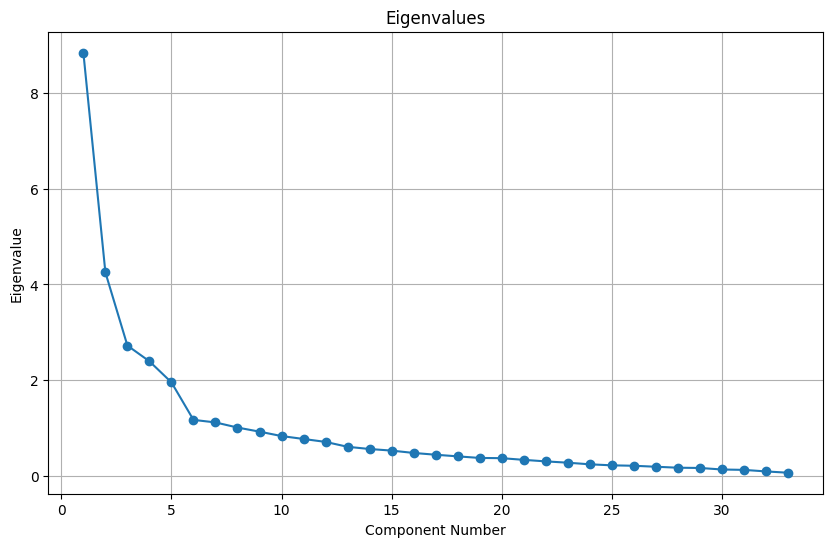

In [ ]:
# apply PCA
X_subset = df_data.drop(['Label'], axis=1).values
y = np.where(df_data['Label'] == 'b', 1, 0)

# Exclude the second feature (all zeros column) from X_subset
X_subset = np.delete(X_subset, 1, axis=1)

# Standardize the features
X_mean = np.mean(X_subset, axis=0)
X_std = np.std(X_subset, axis=0)
X_scaled = (X_subset - X_mean) / X_std


# Step 2: Compute the covariance matrix
def compute_covariance_matrix(X_subset):
    n_samples = X_subset.shape[0]
    cov_matrix = np.zeros((X_subset.shape[1], X_subset.shape[1]))
    for i in range(X_subset.shape[1]):
        for j in range(X_subset.shape[1]):
            cov_matrix[i][j] = np.sum((X_subset[:, i] - np.mean(X_subset[:, i])) * (X_subset[:, j] - np.mean(X_subset[:, j]))) / (n_samples - 1)
    return cov_matrix

cov_matrix = compute_covariance_matrix(X_scaled)

# Step 3: Calculate the eigenvectors and eigenvalues
def calculate_eig(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = calculate_eig(cov_matrix)

# Step 4: Sort the eigenvalues in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Step 5: Select the top k eigenvectors
k = len(X_subset[0])  # Assuming we keep all components for the plot
top_k_eigenvectors = eigenvectors[:, :k]

# Transform the original data onto the new feature subspace
X_pca = X_scaled.dot(top_k_eigenvectors)

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')
plt.grid(True)
plt.savefig("eigenvalues_plot-2.png")
plt.show()

In [ ]:
#@title Test 4: Improved method (Adding higher order feature: False, Regularizatin: False, PCA: True)
# Define the number of top eigenvalues to keep
q = 15

# Create DataFrame with the subset of PCA-transformed features
X_pca_subset = pd.DataFrame(X_pca[:, :q], columns=[f'PC{i+1}_pca' for i in range(q)])

# Concatenate the original DataFrame with the PCA-transformed subset DataFrame
df_pca_subset = pd.concat([df_data[['Label']], X_pca_subset], axis=1)


# Define a dictionary to store PCA
PCA = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization=None, regularization_strength=1) # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X_pca_subset.values, y)
    mean_accuracy = np.mean(accuracies)
    PCA['lr'].append(lr)
    PCA['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    PCA['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display PCA table
results_df = pd.DataFrame(PCA)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 10.0
Accuracy for Fold 1: 0.9142857142857143
Accuracy for Fold 2: 0.7428571428571429
Accuracy for Fold 3: 0.7714285714285715
Accuracy for Fold 4: 0.8
Accuracy for Fold 5: 0.9428571428571428
Accuracy for Fold 6: 0.7714285714285715
Accuracy for Fold 7: 0.9714285714285714
Accuracy for Fold 8: 0.8857142857142857
Accuracy for Fold 9: 0.9142857142857143
Accuracy for Fold 10: 0.8611111111111112
Mean Accuracy : 0.8575396825396826

Evaluating for Learning Rate: 1.0
Accuracy for Fold 1: 0.9142857142857143
Accuracy for Fold 2: 0.9428571428571428
Accuracy for Fold 3: 0.8
Accuracy for Fold 4: 0.9428571428571428
Accuracy for Fold 5: 0.8
Accuracy for Fold 6: 0.8285714285714286
Accuracy for Fold 7: 0.8
Accuracy for Fold 8: 0.8285714285714286
Accuracy for Fold 9: 0.8857142857142857
Accuracy for Fold 10: 0.8333333333333334
Mean Accuracy : 0.8576190476190477

Evaluating for Learning Rate: 0.01
Accuracy for Fold 1: 0.9428571428571428
Accuracy for Fold 2: 0.9142857142857143
Ac

In [ ]:
#@title Overall Table of Results
# Combine results from results1 and results2
results_combined = pd.concat([pd.DataFrame(Baseline), pd.DataFrame(HOF), pd.DataFrame(PCA)], axis=1, keys=['Baseline', 'HOF', 'PCA'])

# Transpose the DataFrame to have learning rates in horizontal order
results_combined_transposed = results_combined.T

# Display combined results table without index numbers
print(results_combined_transposed.to_string())

# Write the DataFrame to an Excel file
results_combined_transposed.to_excel("results-2.xlsx")

                                         0         1         2         3
Baseline lr                      10.000000  1.000000  0.010000  0.001000
         Mean Accuracy            0.866349  0.875000  0.823730  0.689286
         Elapsed Time (seconds)   0.782730  0.762869  0.687675  0.713634
HOF      lr                      10.000000  1.000000  0.010000  0.001000
         Mean Accuracy            0.908810  0.923333  0.888730  0.749206
         Elapsed Time (seconds)   0.802731  0.831905  0.771251  0.727043
PCA      lr                      10.000000  1.000000  0.010000  0.001000
         Mean Accuracy            0.857540  0.857619  0.888810  0.840397
         Elapsed Time (seconds)   0.379571  0.392592  0.394742  0.373020
